# ARCH Model

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from random import randrange

import yfinance as yf # not sure why but it seems VSCode needs yfinance to be imported again
import arch.data.sp500
from arch import arch_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [4]:
# Example: we can get data on the S&P500 index and compute the daily returns (a percentage)
data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

In [5]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000
...,...,...,...,...,...,...
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613930000
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4233990000
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4096610000


In [6]:
# Create a Ticker object
apple_ticker = yf.Ticker("AAPL")

# Fetch historical market data
apple_historical_data = apple_ticker.history(period="max") # data for the entire history of Apple
print("Historical Data:")
apple_historical_data.tail()

Historical Data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-17 00:00:00-05:00,232.119995,232.289993,228.479996,229.979996,68488300,0.0,0.0
2025-01-21 00:00:00-05:00,224.000000,224.419998,219.380005,222.639999,98070400,0.0,0.0
2025-01-22 00:00:00-05:00,219.789993,224.119995,219.789993,223.830002,64126500,0.0,0.0
2025-01-23 00:00:00-05:00,224.740005,227.029999,222.300003,223.660004,60234800,0.0,0.0
2025-01-24 00:00:00-05:00,224.779999,225.630005,221.410004,222.779999,54619500,0.0,0.0


In [7]:
# all data up to the end of 2023
apple_historical_data[:'2023-12-31']

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,194.228458,194.457347,192.029240,192.656174,37122800,0.0,0.0
2023-12-26 00:00:00-05:00,192.666124,192.944757,191.889928,192.108856,28919300,0.0,0.0
2023-12-27 00:00:00-05:00,191.551603,192.556674,190.158419,192.208374,48087700,0.0,0.0


In the following code, we make training and testing datasets from Apple's historical data and then fit GARCH models with parameters $p,q$ ranging from 1 to 5. We compare each of their forecasts to a rolling volatility (with window of size 5) and then look for the best parameters. 

In [8]:
train = apple_historical_data[:'2024-12-01 00:00:00-05:00']['Close'] # for options pricing, we want the volatility of the underlying stock, not the returns
test = apple_historical_data['2024-12-01 00:00:00-05:00':]['Close']

In [9]:
realized_vol = test.rolling(window=5).std().dropna()

# Initialize variables to store results
results = []
best_model = None
best_mse = float('inf')

# Loop over p and q in range(1, 6)
for p in range(1, 6):
    for q in range(1, 6):
        try:
            # Fit a GARCH(p, q) model
            model = arch_model(train, vol='Garch', p=p, q=q, dist='Normal')
            model_fit = model.fit(disp="off")
            
            # Forecast for the test period
            forecast = model_fit.forecast(horizon=len(test))
            # Because the rolling window has to drop some NaN values, we need to align forecast length here
            forecast_vol = np.sqrt(forecast.variance.iloc[-1][:len(realized_vol)])
            
            # Calculate MSE
            mse = np.mean((realized_vol.values - forecast_vol.values) ** 2)
            
            # Store results
            results.append({'p': p, 'q': q, 'MSE': mse})
            
            # Track the best model
            if mse < best_mse:
                best_mse = mse
                best_model = model_fit
        
        except Exception as e:
            print(f"Error with p={p}, q={q}: {e}")

# Convert results to a DataFrame for easier inspection
results_df = pd.DataFrame(results)

# Print and sort results by MSE
print("Best models sorted by MSE:")
print(results_df.sort_values(by='MSE').head())

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best models sorted by MSE:
    p  q           MSE
15  4  1   9053.178471
11  3  2  51816.669293
16  4  2  53747.757204
2   1  3  53827.137919
4   1  5  54660.461961


Let's do the above again but now put into a function that takes in a ticker and gives the hyperparameters for a GARCH model that returns the best MSE.

In [10]:
def bestModel(ticker,date, metric, Window,P,Q):
    """
    Input:
    ticker = str, a stock ticker
    date = 'YYYY-MM-DD' for the cut off date on the training data
    metric = str; open, close, volume, etc
    Window = int, sliding window size
    P = int, max parameter for GARCH
    Q = int, max parameter for GARCH
    """
    # Create a Ticker object
    tick = yf.Ticker(ticker)

    # Fetch historical market data
    historical_data = tick.history(period="max") # data for the entire history of Apple

    train = historical_data[:date][metric] # for options pricing, we want the volatility of the underlying stock, not the returns
    test = historical_data[date:][metric]

    realized_vol = test.rolling(window=Window).std().dropna()

    # Initialize variables to store results
    results = []
    best_model = None
    best_mse = float('inf')

    # Loop over p and q in range(1, 6)
    for p in range(1, P+1):
        for q in range(1, Q+1):
            try:
                # Fit a GARCH(p, q) model
                model = arch_model(train, vol='Garch', p=p, q=q, dist='Normal')
                model_fit = model.fit(disp="off")
                
                # Forecast for the test period
                forecast = model_fit.forecast(horizon=len(test))
                # Because the rolling window has to drop some NaN values, we need to align forecast length here
                forecast_vol = np.sqrt(forecast.variance.iloc[-1][:len(realized_vol)])
                
                # Calculate MSE
                mse = np.mean((realized_vol.values - forecast_vol.values) ** 2)
                
                # Store results
                results.append({'p': p, 'q': q, 'MSE': mse})
                
                # Track the best model
                if mse < best_mse:
                    best_mse = mse
                    best_model = model_fit
            
            except Exception as e:
                print(f"Error with p={p}, q={q}: {e}")

    # Convert results to a DataFrame for easier inspection
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='MSE')

    best_p = int(sorted_results.iloc[0]['p'])
    best_q = int(sorted_results.iloc[0]['q'])

    model = arch_model(train, vol='Garch', p=best_p, q=best_q, dist='Normal')

    # Print and sort results by MSE
    print("Best models sorted by MSE")
    print(sorted_results)
    return model    

In [11]:
best_model = bestModel('AAPL','2023-12-31', 'Close', 5,5,5)

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best models sorted by MSE
    p  q           MSE
2   1  3    490.914175
19  4  5   2266.669311
14  3  5   2863.790954
24  5  5   9894.063636
3   1  4  14177.422844
12  3  3  16911.688960
16  4  2  24724.274958
13  3  4  24786.903822
8   2  4  24795.807331
5   2  1  24808.329722
21  5  2  24811.548549
1   1  2  24822.488706
7   2  3  25443.176659
4   1  5  25455.971118
0   1  1  25508.110744
22  5  3  25548.578363
10  3  1  25576.006916
18  4  4  25592.782690
23  5  4  25658.316701
11  3  2  25698.317535
9   2  5  29548.426301
17  4  3  29550.928921
15  4  1  30767.059159
20  5  1  35603.290256
6   2  2  46048.562155


In [12]:
train = apple_historical_data[:'2023-12-31']['Close'] # for options pricing, we want the volatility of the underlying stock, not the returns
test = apple_historical_data['2023-12-31':]['Close']

In [13]:
realized_vol = test.rolling(window=5).std().dropna()

best_model_fit = best_model.fit()

# Forecast for the test period
forecast = best_model_fit.forecast(horizon=len(test))
# Because the rolling window has to drop some NaN values, we need to align forecast length here
forecast_vol = np.sqrt(forecast.variance.iloc[-1][:len(realized_vol)])

# Calculate MSE
print(np.mean((realized_vol.values - forecast_vol.values) ** 2))

Iteration:      1,   Func. Count:      8,   Neg. LLF: 39478471.79987798
Iteration:      2,   Func. Count:     17,   Neg. LLF: 63797.732214798874
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1095210.362606496
Iteration:      4,   Func. Count:     34,   Neg. LLF: 38963.3080110656
Iteration:      5,   Func. Count:     41,   Neg. LLF: 40911.106079944846
Iteration:      6,   Func. Count:     49,   Neg. LLF: 35530968447436.42
Iteration:      7,   Func. Count:     64,   Neg. LLF: 163784388.82483107
Iteration:      8,   Func. Count:     81,   Neg. LLF: 68444.36984221237
Iteration:      9,   Func. Count:     88,   Neg. LLF: 705193666099.0171
Iteration:     10,   Func. Count:     97,   Neg. LLF: 19579089099.245335
Iteration:     11,   Func. Count:    105,   Neg. LLF: 103572414679348.19
Iteration:     12,   Func. Count:    114,   Neg. LLF: 11436378518.836567
Iteration:     13,   Func. Count:    130,   Neg. LLF: 67504.7990461776
Iteration:     14,   Func. Count:    139,   Neg. LLF: 45264.

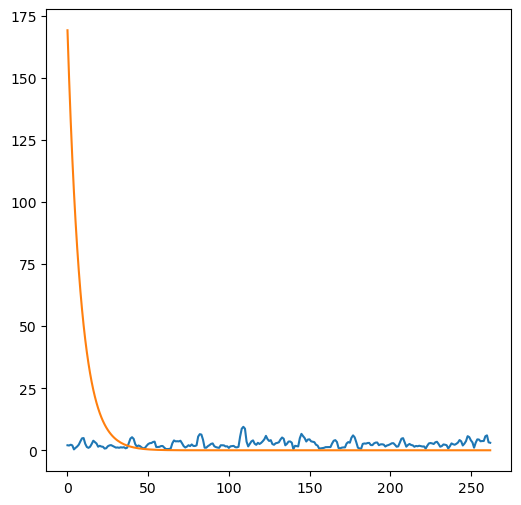

In [14]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.plot(realized_vol.values)#, color = 'b', alpha = 0.3)
plt.plot(forecast_vol.values)#, color = 'r', alpha = 0.3)
#plt.xlabel('Date')

#plt.title('Rolling Volatility (n=30)')
#plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

**Confusion:** The MSE don't match; are there random states in the training?

The above code should be easily modified if we want to try EGARCH or TARCH. For example, first import:
`from arch.univariate import EGARCH`

The code below scrapes Wikipedia for a list of the S&P500 companies and then gives a way to randomly select a ticker and get data on it from Yahoo Finance.

In [15]:
def get_tickers():
    
    # Scrape the Wikipedia page related to the S&P500 
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable sticky-header'})
    tickers = []

    # Import stock tickers
    for row in table.findAll('tr')[2:]: 
        ticker_info = (row.findAll('td')[0].text.replace('\n', ''), row.findAll('td')[1].text, row.findAll('td')[2].text)
        tickers.append(ticker_info)
    
    return tickers

In [16]:
list = get_tickers()
list

[('AOS', 'A. O. Smith', 'Industrials'),
 ('ABT', 'Abbott Laboratories', 'Health Care'),
 ('ABBV', 'AbbVie', 'Health Care'),
 ('ACN', 'Accenture', 'Information Technology'),
 ('ADBE', 'Adobe Inc.', 'Information Technology'),
 ('AMD', 'Advanced Micro Devices', 'Information Technology'),
 ('AES', 'AES Corporation', 'Utilities'),
 ('AFL', 'Aflac', 'Financials'),
 ('A', 'Agilent Technologies', 'Health Care'),
 ('APD', 'Air Products', 'Materials'),
 ('ABNB', 'Airbnb', 'Consumer Discretionary'),
 ('AKAM', 'Akamai Technologies', 'Information Technology'),
 ('ALB', 'Albemarle Corporation', 'Materials'),
 ('ARE', 'Alexandria Real Estate Equities', 'Real Estate'),
 ('ALGN', 'Align Technology', 'Health Care'),
 ('ALLE', 'Allegion', 'Industrials'),
 ('LNT', 'Alliant Energy', 'Utilities'),
 ('ALL', 'Allstate', 'Financials'),
 ('GOOGL', 'Alphabet Inc. (Class A)', 'Communication Services'),
 ('GOOG', 'Alphabet Inc. (Class C)', 'Communication Services'),
 ('MO', 'Altria', 'Consumer Staples'),
 ('AMZN',

In [17]:
# Pick a random stock (without repetition) from a list
def random_picker(list):   
    i = randrange(len(list))
    random_stock = list[i]
    
    return random_stock

In [18]:
random_picker(list)

('WM', 'Waste Management', 'Industrials')

In [19]:
# Get n stocks from S&P500, some dataframes are empty
n=10
k=0
period = '1y'
prices = []
stock_names=[]
stock_symbols=[]
while k<n:
    name = random_picker(list)
    ticker = yf.Ticker(name[0])
    stock_prices = ticker.history(period=period)
    if not stock_prices.empty:
        stock_names.append(name)
        stock_symbols.append(name[0])
        prices.append(stock_prices)
        k+=1

In [20]:
stock_names

[('XEL', 'Xcel Energy', 'Utilities'),
 ('AIZ', 'Assurant', 'Financials'),
 ('EQIX', 'Equinix', 'Real Estate'),
 ('ALL', 'Allstate', 'Financials'),
 ('EQIX', 'Equinix', 'Real Estate'),
 ('CPAY', 'Corpay', 'Financials'),
 ('HPE', 'Hewlett Packard Enterprise', 'Information Technology'),
 ('BG', 'Bunge Global', 'Consumer Staples'),
 ('DVA', 'DaVita', 'Health Care'),
 ('DVA', 'DaVita', 'Health Care')]

In [21]:
# combines columns labeled 'Value' from dataframes that are placed in a list (so each dataframe needs 'Value' as a column)
# adds an average value column and also daily return % column

def combine(prices,value):
    # Concatenate the value columns
    combined = pd.concat([df[value] for df in prices], axis=1)

    combined.columns = stock_symbols

    combined = combined.dropna(axis=1)

    # Calculate the average value price for each day
    combined['Average_' + value] = combined.mean(axis=1)
    combined['Daily Returns %'] = ((combined['Average_'+value]/combined['Average_'+value].shift(1))-1)*100
    return combined

In [22]:
combined = combine(prices,'Close')
combined.head()

,XEL,AIZ,EQIX,ALL,EQIX,CPAY,HPE,BG,DVA,DVA,Average_Close,Daily Returns %
Date,,,,,,,,,,,,
2024-01-25 00:00:00-05:00,56.711239,168.665817,799.076050,155.801117,799.076050,293.799988,15.500859,85.957550,107.430000,107.430000,258.944867,NaN
2024-01-26 00:00:00-05:00,57.192734,168.025925,794.832275,155.125244,794.832275,294.010010,15.422966,85.811775,107.169998,107.169998,257.959320,-0.380601
2024-01-29 00:00:00-05:00,57.452747,166.696930,815.198547,152.862579,815.198547,297.269989,15.384019,86.501778,108.309998,108.309998,262.318513,1.689876
2024-01-30 00:00:00-05:00,57.549049,167.445084,824.822998,153.283768,824.822998,296.929993,15.471651,87.755424,107.519997,107.519997,264.312096,0.759985
2024-01-31 00:00:00-05:00,57.654980,165.338364,813.248169,152.069183,813.248169,289.929993,14.887446,85.607689,108.160004,108.160004,260.830400,-1.317267


Let's now find the best GARCH parameters for a random ticker from S&P500. Hopefully, the company has existed long enough for the chosen date to make sense.

In [23]:
tick = random_picker(list)[0]
print(tick)

EG


In [24]:
best_model = bestModel(tick,'2023-12-31', 'Close', 5,5,5)

Best models sorted by MSE
    p  q           MSE
20  5  1  79131.280967
21  5  2  79131.297673
15  4  1  79131.298094
24  5  5  79131.319418
16  4  2  79131.327420
19  4  5  79131.336476
18  4  4  79131.348429
22  5  3  79131.373837
17  4  3  79131.374419
23  5  4  79131.375251
12  3  3  79158.050186
9   2  5  79158.063210
7   2  3  79158.094854
8   2  4  79158.115236
13  3  4  79158.117283
14  3  5  79158.120479
4   1  5  79161.529571
3   1  4  79161.561810
2   1  3  79161.604564
6   2  2  79231.073232
1   1  2  79231.080214
11  3  2  79231.106759
10  3  1  79240.478192
0   1  1  79253.588917
5   2  1  79253.645483
